In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
import seaborn as sns
import tensorflow 
print(tensorflow.__version__)
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.constraints import maxnorm
from PIL import Image
from PIL import ImageMath

2.4.1


In [3]:
warnings.filterwarnings('ignore')

In [4]:
os.chdir("/content/drive/MyDrive/CNN")
from zipfile import ZipFile
with ZipFile('Dataset - Plant-seedlings-classification.zip', 'r') as z:
  z.extractall()
  !ls

 Dataset					 mobile-images.zip
'Dataset - Images.zip'				 sample_submission.csv
'Dataset - Plant-seedlings-classification.zip'	 test
'Dataset - Prediction.zip'			 train
 mobile-images					 weights_itr_1


In [5]:
#see contents of train file
!ls train

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [100]:
import cv2

In [7]:
from glob import glob

In [8]:
TRAin_DATA_FOLDER= "train"

Reading images and removing missing values and save images in images list

In [9]:
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAin_DATA_FOLDER):
    class_folder_path = os.path.join(TRAin_DATA_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missig value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

In [10]:
len(images)

4750

resizing images

In [11]:

def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(128,128), interpolation = cv2.INTER_CUBIC)
  return res
#resized=[]
#for image in images:
#  ressized= resize_images(images[image])

In [12]:
#save resized images into images.
images = [resize_images(img) for img in images]

In [13]:
images[0].shape

(128, 128, 3)

Showing the number of images in each class

In [14]:
#see number of images in each lablel
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)
#for key,value in images_per_class.items():
   # print("number of {0} images is  -> {1}".format(key, len(value)))
  
for label in set(classes):

  print("number of {} images is  -> {}".format(
        label, 
        len(images[classes == label])))

images shape:  (4750, 128, 128, 3)
classes shape:  (4750,)
number of Charlock images is  -> 390
number of Common Chickweed images is  -> 611
number of Maize images is  -> 221
number of Small-flowered Cranesbill images is  -> 496
number of Cleavers images is  -> 287
number of Shepherds Purse images is  -> 231
number of Sugar beet images is  -> 385
number of Loose Silky-bent images is  -> 654
number of Fat Hen images is  -> 475
number of Common wheat images is  -> 221
number of Black-grass images is  -> 263
number of Scentless Mayweed images is  -> 516


Distribution plot

Text(0.5, 0.98, 'Categorical Plotting')

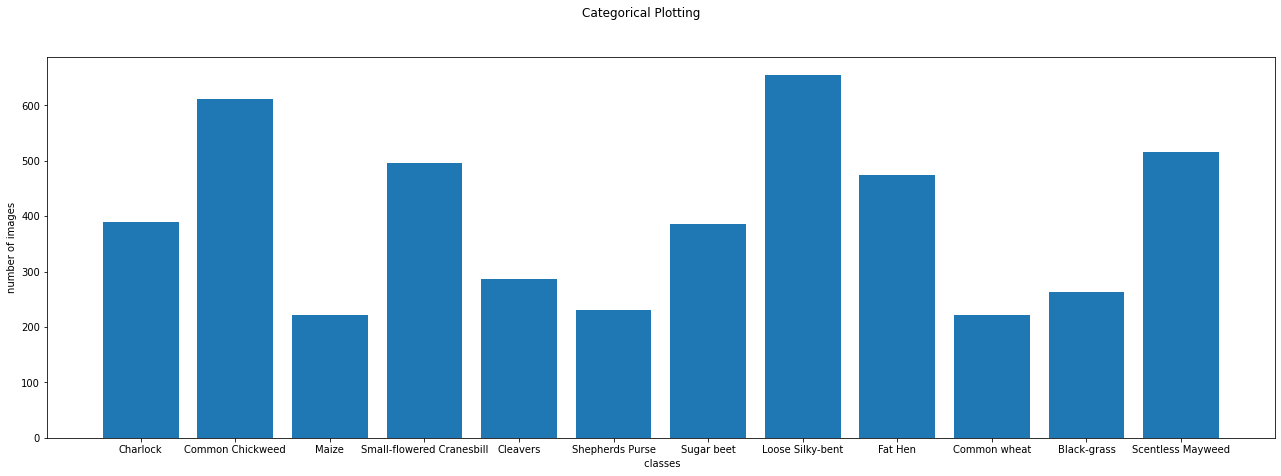

In [15]:
values =[]
labels=[]
for label in set(classes):
  values.append(len(images[classes == label]))
  labels.append(label)

fig, ax = plt.subplots(figsize=(22,7))
ax.bar(labels, values)
ax.set_xlabel(" classes")
ax.set_ylabel("number of images")
#axs[1].scatter(label, )
  #axs[2].plot(names, values)
fig.suptitle('Categorical Plotting')

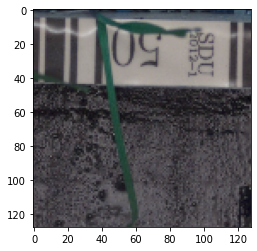

In [16]:
plt.imshow(images[50])

Data Exploration

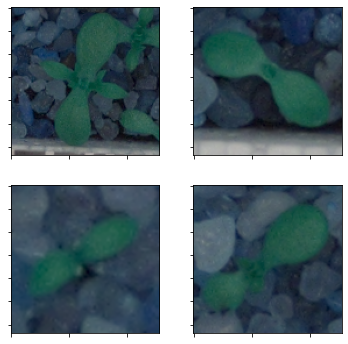

In [17]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =images[classes== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1 
plot_for_class("Scentless Mayweed")

In [18]:
#!ls "train/Scentless Mayweed" 1300c3cd9.png

img = cv2.imread("train/Scentless Mayweed/1300c3cd9.png")

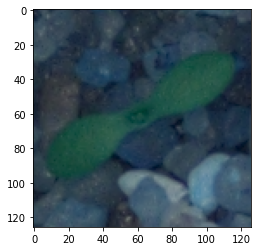

In [19]:
plt.imshow(img)

Applying image processing on the images

In [20]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [21]:
def segment(img):

  #image_mask = create_mask_for_plant(img)
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

Iterating the images

In [22]:
for indx, image in enumerate(images):
  try:
     images[indx] = segment(image)
      
  except:
    print(indx)
    continue

Sample image to see the difference

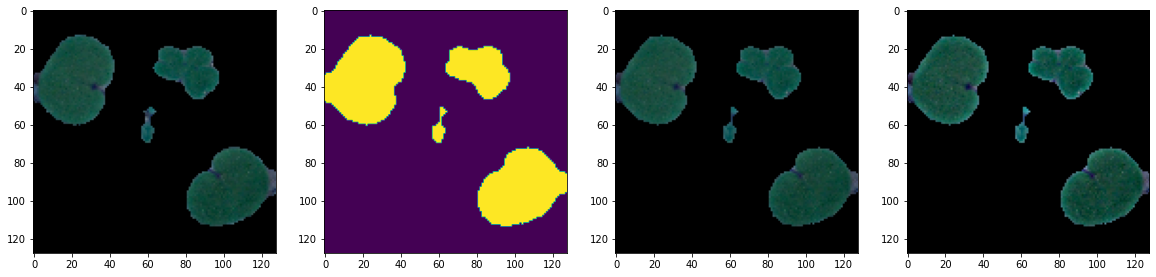

In [23]:
image = images[classes == "Small-flowered Cranesbill"][40]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

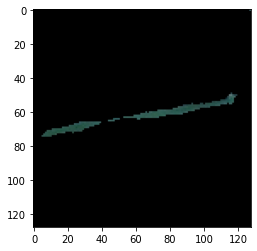

In [24]:
plt.imshow(images[0])

In [25]:
images.shape

(4750, 128, 128, 3)

Label Encoder

In [26]:

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(classes)

In [27]:
y[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Split the data into train and test

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)

In [29]:
X_train.shape

(3325, 128, 128, 3)

In [30]:
y_train.shape

(3325, 12)

In [31]:
y_test.shape

(1425, 12)

Normalize the data

In [32]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

Applying supervised learning algorithms

In [33]:
def convert_image(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = img_gray.flatten()
    return img_gray

In [34]:
X_train_changed = np.array([convert_image(x) for x in X_train])
X_test_changed = np.array([convert_image(x) for x in X_test])

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train_changed)
X_test_pca = pca.transform(X_test_changed)

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score

In [39]:
models = []

models.append(('KNN', KNeighborsClassifier(n_neighbors=11)))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))


In [40]:
results = list()
names = list()

for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train_pca, y_train, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s : %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN : 0.264364 (0.020022)
DT : 0.339279 (0.035492)
RF : 0.006615 (0.003983)


Decision tree shows better accuracy 

Using neural networks

In [42]:
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, BatchNormalization, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.initializers import HeUniform

In [43]:
X_train_new = np.array([convert_image(x) for x in X_train])
X_test_new = np.array([convert_image(x) for x in X_test])

In [45]:
X_train_new = X_train_new.reshape(3325, 16384)
X_test_new = X_test_new.reshape(1425, 16384)

Building the model by using sgd optimizer

In [46]:
def create_model(layers, optimizer, loss, metrics, epochs, batch_size, callbacks):
  model = tf.keras.Sequential()
  for layer in layers:
    model.add(layer)  
  print(model.summary())

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  history = model.fit(X_train_new, y_train, validation_data=(X_test_new, y_test), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=callbacks)
  return history

In [47]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(32, input_shape=(16384,)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))         
model.add(tf.keras.layers.Dense(256, activation='relu'))                   
model.add(tf.keras.layers.Dense(12, activation='softmax'))

In [48]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                524320    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 12)                3084      
Total params: 570,860
Trainable params: 570,860
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
sgd = tf.keras.optimizers.SGD(lr = 0.001)
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [50]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='weights_itr_1', verbose=2, save_best_only=True)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2)

In [51]:
history = model.fit(X_train_new, y_train, validation_data=(X_test_new, y_test), epochs=100, batch_size=128, verbose=2, callbacks=[checkpoint, earlystopping])

Epoch 1/100
26/26 - 2s - loss: 2.4849 - accuracy: 0.0959 - val_loss: 2.4832 - val_accuracy: 0.1004

Epoch 00001: val_loss improved from inf to 2.48323, saving model to weights_itr_1
INFO:tensorflow:Assets written to: weights_itr_1/assets
Epoch 2/100
26/26 - 1s - loss: 2.4831 - accuracy: 0.1077 - val_loss: 2.4815 - val_accuracy: 0.1172

Epoch 00002: val_loss improved from 2.48323 to 2.48152, saving model to weights_itr_1
INFO:tensorflow:Assets written to: weights_itr_1/assets
Epoch 3/100
26/26 - 1s - loss: 2.4812 - accuracy: 0.1179 - val_loss: 2.4797 - val_accuracy: 0.1326

Epoch 00003: val_loss improved from 2.48152 to 2.47967, saving model to weights_itr_1
INFO:tensorflow:Assets written to: weights_itr_1/assets
Epoch 4/100
26/26 - 1s - loss: 2.4793 - accuracy: 0.1281 - val_loss: 2.4778 - val_accuracy: 0.1460

Epoch 00004: val_loss improved from 2.47967 to 2.47777, saving model to weights_itr_1
INFO:tensorflow:Assets written to: weights_itr_1/assets
Epoch 5/100
26/26 - 1s - loss: 2.477

In [52]:
val_loss, val_acc = model.evaluate(X_test_new,y_test)
print(val_loss, val_acc)

45/45 [==============================] - 0s 3ms/step - loss: 2.1671 - accuracy: 0.3018
2.167144775390625 0.3017543852329254


Model accuracy using sgd is around 30%, so will try adding more dense layers and using adam optimizer

In [53]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(32, input_shape=(16384,)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))        
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))                   
model.add(tf.keras.layers.Dense(12, activation='softmax'))

In [54]:
adam = tf.keras.optimizers.Adam(lr = 0.001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [55]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='weights_itr_1', verbose=2, save_best_only=True)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2)

In [56]:
history = model.fit(X_train_new, y_train, validation_data=(X_test_new, y_test), epochs=100, batch_size=128, verbose=2, callbacks=[checkpoint, earlystopping])

Epoch 1/100
26/26 - 1s - loss: 2.2083 - accuracy: 0.2328 - val_loss: 1.9736 - val_accuracy: 0.3158

Epoch 00001: val_loss improved from inf to 1.97361, saving model to weights_itr_1
INFO:tensorflow:Assets written to: weights_itr_1/assets
Epoch 2/100
26/26 - 1s - loss: 1.7916 - accuracy: 0.3898 - val_loss: 1.7737 - val_accuracy: 0.3867

Epoch 00002: val_loss improved from 1.97361 to 1.77375, saving model to weights_itr_1
INFO:tensorflow:Assets written to: weights_itr_1/assets
Epoch 3/100
26/26 - 1s - loss: 1.5059 - accuracy: 0.4644 - val_loss: 1.6631 - val_accuracy: 0.4218

Epoch 00003: val_loss improved from 1.77375 to 1.66312, saving model to weights_itr_1
INFO:tensorflow:Assets written to: weights_itr_1/assets
Epoch 4/100
26/26 - 1s - loss: 1.2914 - accuracy: 0.5248 - val_loss: 1.6101 - val_accuracy: 0.4456

Epoch 00004: val_loss improved from 1.66312 to 1.61007, saving model to weights_itr_1
INFO:tensorflow:Assets written to: weights_itr_1/assets
Epoch 5/100
26/26 - 1s - loss: 1.116

In [57]:
val_loss, val_acc = model.evaluate(X_test_new,y_test)
print(val_loss, val_acc)

45/45 [==============================] - 0s 3ms/step - loss: 2.7354 - accuracy: 0.4982
2.7354354858398438 0.49824562668800354


with adding more layers and using optimizer Adam the model gave better accuracy of about 49%

In [58]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(32, input_shape=(16384,)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())       
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())                  
model.add(tf.keras.layers.Dense(12, activation='softmax'))


In [59]:
adam = tf.keras.optimizers.Adam(lr = 0.001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [60]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='weights_itr_1', verbose=2, save_best_only=True)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2)

In [61]:
history = model.fit(X_train_new, y_train, validation_data=(X_test_new, y_test), epochs=100, batch_size=128, verbose=2, callbacks=[checkpoint, earlystopping])

Epoch 1/100
26/26 - 3s - loss: 2.1514 - accuracy: 0.3089 - val_loss: 2.3766 - val_accuracy: 0.0856

Epoch 00001: val_loss improved from inf to 2.37660, saving model to weights_itr_1
INFO:tensorflow:Assets written to: weights_itr_1/assets
Epoch 2/100
26/26 - 1s - loss: 1.4216 - accuracy: 0.4926 - val_loss: 2.2677 - val_accuracy: 0.1544

Epoch 00002: val_loss improved from 2.37660 to 2.26772, saving model to weights_itr_1
INFO:tensorflow:Assets written to: weights_itr_1/assets
Epoch 3/100
26/26 - 1s - loss: 1.1688 - accuracy: 0.5919 - val_loss: 2.0671 - val_accuracy: 0.2954

Epoch 00003: val_loss improved from 2.26772 to 2.06707, saving model to weights_itr_1
INFO:tensorflow:Assets written to: weights_itr_1/assets
Epoch 4/100
26/26 - 1s - loss: 0.9684 - accuracy: 0.6493 - val_loss: 1.8654 - val_accuracy: 0.3818

Epoch 00004: val_loss improved from 2.06707 to 1.86540, saving model to weights_itr_1
INFO:tensorflow:Assets written to: weights_itr_1/assets
Epoch 5/100
26/26 - 1s - loss: 0.836

In [62]:
val_loss, val_acc = model.evaluate(X_test_gray,y_test)
print(val_loss, val_acc)

45/45 [==============================] - 0s 3ms/step - loss: 2.0510 - accuracy: 0.5600
2.05100154876709 0.5600000023841858


Including batch normalization and adam optimizer gave a better accuracy of 56%. So will conclude by using this iteration as the best compared to others

Using CNN

In [63]:
print('The shape of X_train:', X_train.shape)
print('The shape of X_test:', X_test.shape)

The shape of X_train: (3325, 128, 128, 3)
The shape of X_test: (1425, 128, 128, 3)


In [64]:
y_train.shape

(3325, 12)

In [65]:
y_test.shape

(1425, 12)

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [67]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(128,128,3))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2) , strides =(1,1),  padding='valid' ))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2 , padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(12, activation='softmax'))

In [68]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 127, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 127008)            0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               32514304  
_________________________________________________________________
dropout (Dropout)            (None, 256)              

In [69]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [70]:
history = model.fit(X_train,y_train, validation_data=(X_test,y_test),epochs = 30, batch_size = 32)

Epoch 1/30
104/104 [==============================] - 286s 3s/step - loss: 2.3821 - accuracy: 0.1814 - val_loss: 1.8220 - val_accuracy: 0.3804
Epoch 2/30
104/104 [==============================] - 282s 3s/step - loss: 1.8541 - accuracy: 0.3634 - val_loss: 1.6023 - val_accuracy: 0.4505
Epoch 3/30
104/104 [==============================] - 285s 3s/step - loss: 1.6257 - accuracy: 0.4397 - val_loss: 1.4878 - val_accuracy: 0.4877
Epoch 4/30
104/104 [==============================] - 281s 3s/step - loss: 1.4713 - accuracy: 0.4821 - val_loss: 1.4126 - val_accuracy: 0.5186
Epoch 5/30
104/104 [==============================] - 288s 3s/step - loss: 1.3671 - accuracy: 0.5170 - val_loss: 1.3720 - val_accuracy: 0.5130
Epoch 6/30
104/104 [==============================] - 282s 3s/step - loss: 1.2584 - accuracy: 0.5561 - val_loss: 1.2029 - val_accuracy: 0.5832
Epoch 7/30
104/104 [==============================] - 281s 3s/step - loss: 1.1147 - accuracy: 0.6096 - val_loss: 1.1170 - val_accuracy: 0.6239

In [71]:
score = model.evaluate(X_test, y_test)
print("Test Loss" , score[0])
print("Test Accuracy" , score [1])


45/45 [==============================] - 23s 522ms/step - loss: 1.1947 - accuracy: 0.6912
Test Loss 1.194675087928772
Test Accuracy 0.6912280917167664


In [73]:
score1 = model.evaluate(X_train, y_train)
print("Train Loss" , score1[0])
print("Train Accuracy" , score1 [1])


104/104 [==============================] - 55s 526ms/step - loss: 0.0646 - accuracy: 0.9892
Train Loss 0.0645919144153595
Train Accuracy 0.9891729354858398


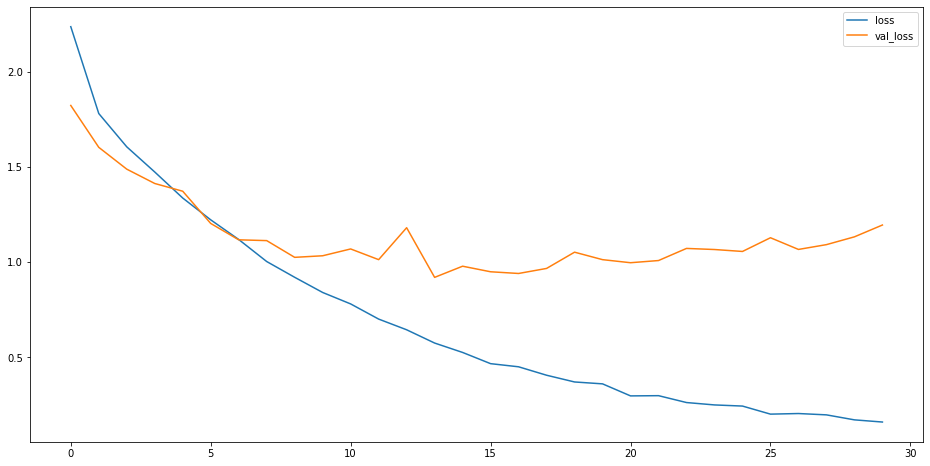

In [74]:
plt.figure(figsize=(16, 8))
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Though train accuracy is 99%, testing showed about 70% accuracy which can be concluded to be a good model

Checking another iteration if accuracy is any better

In [75]:
import tensorflow as tf

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(128,128,3))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2) , strides =(2,2),  padding='valid' ))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2 , padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(12, activation='softmax'))

In [76]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [77]:
history = model.fit(X_train,y_train, validation_data=(X_test,y_test),epochs = 30, batch_size = 64)

Epoch 1/30
52/52 [==============================] - 289s 6s/step - loss: 8.1674 - accuracy: 0.4199 - val_loss: 1.2308 - val_accuracy: 0.6021
Epoch 2/30
52/52 [==============================] - 279s 5s/step - loss: 1.1707 - accuracy: 0.5902 - val_loss: 1.0421 - val_accuracy: 0.6660
Epoch 3/30
52/52 [==============================] - 279s 5s/step - loss: 0.8717 - accuracy: 0.7040 - val_loss: 1.0008 - val_accuracy: 0.6807
Epoch 4/30
52/52 [==============================] - 281s 5s/step - loss: 0.6957 - accuracy: 0.7569 - val_loss: 0.9770 - val_accuracy: 0.6828
Epoch 5/30
52/52 [==============================] - 279s 5s/step - loss: 0.5975 - accuracy: 0.7897 - val_loss: 0.9161 - val_accuracy: 0.7088
Epoch 6/30
52/52 [==============================] - 279s 5s/step - loss: 0.4822 - accuracy: 0.8488 - val_loss: 0.9362 - val_accuracy: 0.7046
Epoch 7/30
52/52 [==============================] - 288s 6s/step - loss: 0.3985 - accuracy: 0.8671 - val_loss: 0.9928 - val_accuracy: 0.7102
Epoch 8/30
52

In [78]:
score = model.evaluate(X_test, y_test)
print("Test Loss" , score[0])
print("Test Accuracy" , score [1])

45/45 [==============================] - 24s 533ms/step - loss: 1.5478 - accuracy: 0.7081
Test Loss 1.5477946996688843
Test Accuracy 0.7080701589584351


Comparing models

In [81]:
dnn_model = Sequential()
dnn_model.add(Dense(32, input_shape=(16384,)))
dnn_model.add(Dense(64, activation='relu'))
dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(BatchNormalization())
dnn_model.add(Dense(256, activation='relu'))
dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(512, activation='relu'))
dnn_model.add(Dense(12, activation='softmax'))

adam = Adam(learning_rate=0.0001, amsgrad=True)
dnn_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=2)
]

histroy_dnn_model = dnn_model.fit(X_train_new, y_train, validation_data=(X_test_new, y_test), epochs=100, batch_size=128, callbacks=callbacks)

print('\nThe training accuracy using DNN', dnn_model.evaluate(X_train_gray, y_train))
print('The testing accuracy using DNN', dnn_model.evaluate(X_test_gray, y_test))

Epoch 1/100
26/26 [==============================] - 2s 54ms/step - loss: 2.4225 - accuracy: 0.1595 - val_loss: 2.4209 - val_accuracy: 0.1825
Epoch 2/100
26/26 [==============================] - 1s 26ms/step - loss: 2.1061 - accuracy: 0.3287 - val_loss: 2.3424 - val_accuracy: 0.2814
Epoch 3/100
26/26 [==============================] - 1s 26ms/step - loss: 1.9022 - accuracy: 0.3639 - val_loss: 2.2531 - val_accuracy: 0.3432
Epoch 4/100
26/26 [==============================] - 1s 25ms/step - loss: 1.7480 - accuracy: 0.4100 - val_loss: 2.1436 - val_accuracy: 0.3628
Epoch 5/100
26/26 [==============================] - 1s 26ms/step - loss: 1.6563 - accuracy: 0.4402 - val_loss: 2.0482 - val_accuracy: 0.4119
Epoch 6/100
26/26 [==============================] - 1s 26ms/step - loss: 1.5641 - accuracy: 0.4611 - val_loss: 1.9519 - val_accuracy: 0.4281
Epoch 7/100
26/26 [==============================] - 1s 26ms/step - loss: 1.4678 - accuracy: 0.4846 - val_loss: 1.8598 - val_accuracy: 0.4575
Epoch 

In [83]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3), input_shape=X_train.shape[1:], activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(256, activation='relu')),
cnn_model.add(Dense(12, activation='softmax'))

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=2)
]

cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=128, callbacks=callbacks)

print('\nThe training accuracy using CNN', cnn_model.evaluate(X_train, y_train))
print('The testing accuracy using CNN', cnn_model.evaluate(X_test, y_test))

Epoch 1/30
26/26 [==============================] - 136s 5s/step - loss: 3.0839 - accuracy: 0.1696 - val_loss: 2.4116 - val_accuracy: 0.1881
Epoch 2/30
26/26 [==============================] - 134s 5s/step - loss: 1.1744 - accuracy: 0.6032 - val_loss: 2.3811 - val_accuracy: 0.2112
Epoch 3/30
26/26 [==============================] - 134s 5s/step - loss: 0.8214 - accuracy: 0.7202 - val_loss: 2.3604 - val_accuracy: 0.1979
Epoch 4/30
26/26 [==============================] - 134s 5s/step - loss: 0.6466 - accuracy: 0.7745 - val_loss: 2.2959 - val_accuracy: 0.2554
Epoch 5/30
26/26 [==============================] - 134s 5s/step - loss: 0.4576 - accuracy: 0.8510 - val_loss: 2.2149 - val_accuracy: 0.3768
Epoch 6/30
26/26 [==============================] - 134s 5s/step - loss: 0.3477 - accuracy: 0.8817 - val_loss: 2.1211 - val_accuracy: 0.5593
Epoch 7/30
26/26 [==============================] - 134s 5s/step - loss: 0.2281 - accuracy: 0.9254 - val_loss: 1.9899 - val_accuracy: 0.5032
Epoch 8/30
26

Creating confusion matrix for all the models

In [84]:
dnn_pred_ = dnn_model.predict(X_test_new)
cnn_pred_ = cnn_model.predict(X_test)

In [85]:
from sklearn.metrics import confusion_matrix, classification_report

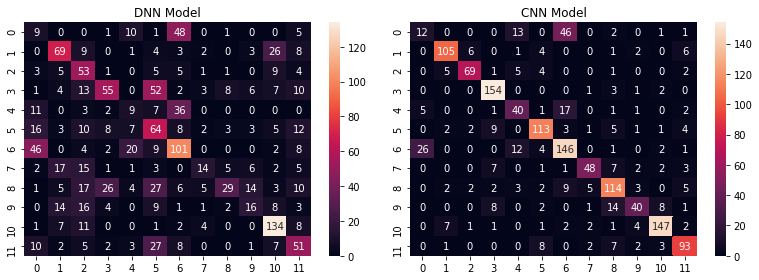

In [87]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 3, 2, title='DNN Model')
sns.heatmap(confusion_matrix(y_test.argmax(axis=1), dnn_pred_.argmax(axis=1)), annot=True, fmt='g')

ax = fig.add_subplot(1, 3, 3, title='CNN Model')
sns.heatmap(confusion_matrix(y_test.argmax(axis=1), cnn_pred_.argmax(axis=1)), annot=True, fmt='g')

fig.tight_layout()
plt.show()

In [88]:
print('DNN Model Classification Report')
print(classification_report(y_test.argmax(axis=1), dnn_pred_.argmax(axis=1)))

DNN Model Classification Report
              precision    recall  f1-score   support

           0       0.09      0.12      0.10        75
           1       0.55      0.55      0.55       125
           2       0.34      0.61      0.44        87
           3       0.54      0.34      0.42       161
           4       0.16      0.13      0.15        68
           5       0.31      0.45      0.37       141
           6       0.46      0.53      0.49       192
           7       0.44      0.20      0.27        71
           8       0.59      0.20      0.30       147
           9       0.33      0.22      0.26        74
          10       0.66      0.80      0.72       168
          11       0.41      0.44      0.43       116

    accuracy                           0.42      1425
   macro avg       0.41      0.38      0.37      1425
weighted avg       0.45      0.42      0.41      1425



In [89]:
print('CNN Model Classification Report')
print(classification_report(y_test.argmax(axis=1), cnn_pred_.argmax(axis=1)))

CNN Model Classification Report
              precision    recall  f1-score   support

           0       0.28      0.16      0.20        75
           1       0.86      0.84      0.85       125
           2       0.86      0.79      0.83        87
           3       0.84      0.96      0.90       161
           4       0.54      0.59      0.56        68
           5       0.81      0.80      0.80       141
           6       0.65      0.76      0.70       192
           7       0.80      0.68      0.73        71
           8       0.73      0.78      0.75       147
           9       0.71      0.54      0.62        74
          10       0.89      0.88      0.88       168
          11       0.78      0.80      0.79       116

    accuracy                           0.76      1425
   macro avg       0.73      0.71      0.72      1425
weighted avg       0.75      0.76      0.75      1425



To conclude CNN Model performance is the best

Pickle the model

In [90]:
cnn_model.save('best_model.h5')

In [91]:
import pickle
pickle.dump(cnn_model.get_weights(), open('best_weight.pkl', 'wb'))

In [ ]:
test_img = cv2.imread('Dataset - Prediction.zip/Prediction/Predict.png')

plt.imshow(test_img)

In [ ]:
test_img = extract_plant(test_img)
test_img = cv2.resize(test_img, (128, 128))
plt.imshow(test_img)

In [ ]:
test_img = test_img.reshape(1, 128, 128, 3)

In [98]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5')

In [ ]:
predict = best_model.predict(test_img)

In [ ]:
encoder.inverse_transform(predict.argmax(axis=1))

In [ ]:
input_data = []
file_names = []
for i in os.listdir('Dataset/test/'):
    img = cv2.imread('Dataset/test/{}'.format(i))
    img = extract_plant(img)
    img = cv2.resize(img, (128, 128))
    input_data.append(img)
    file_names.append(i)

In [ ]:
input_data = np.asarray(input_data)
print('The shape of input data for prediction:', input_data.shape)

In [ ]:
predict = cnn_model.predict(input_data)

In [ ]:
submission = pd.DataFrame(file_names, columns=['file'])
submission['species'] = encoder.inverse_transform(predict.argmax(axis=1))

In [ ]:
submission.to_csv('Submission1.csv', index=False)

Observations:
Using various machine learning techniques and deep learning and computer vision for the image classifier it can be concluded that by far computer vision provides the best accuracy than any other.

And in comparison to supervised learning and neural networks, deep neural network showed better accuracy.

Final comparison showed that CNN provided almost 50% best accuracy than any other techniques.

Supervised learning accuracy was - KNN - 26%, DT - 34% and RF - bare minimal
NN - using optimizers - sgd - 30% and adam - 49% , however with batch normalization and adam optimizer it imporoved to 56%

CNN with multiple iterations improved accuracy from 70 to 75%

REASON WHY CNN IS SUPERIOR THAN SL OR NN in image classification:

It is already proven that CNN outperforms in terms of accuracy, works better with large datasets, can be worked on various domains, no feature engineering is involved, scaling is effective and less time consuming.